In [1]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions

In [3]:
sparse_sessions.keys()

dict_keys(['SparseKO_05', 'SparseKO_02', 'SparseKO_03', 'SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

In [111]:
mouse = 'SparseKO_06'
d = sparse_sessions[mouse][-2]
print(d)

{'date': '01_06_2025', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 16, 'novel_arm': 1, 'exp_day': 7}


In [112]:
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
print(scene)
basedir = f'Z://giocomo/InVivoDA/2P_Data/{mouse}/{date}/{scene}'
stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })

YMaze_LNovel_LongTimeout


In [113]:
sess = stx.session.YMazeSession(**d)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P()
sess.load_suite2p_data(which_ts=('F', 'Fneu'))
sess.get_trial_info()


Fixing teleports
frame rate 15.625
(201655,) ttl times,(44945,) ca2+ frame times
last time: VR 2876.51825, ca2+ 2876.416


c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:259: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:265: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


['Z://giocomo/InVivoDA/2P_Data/SparseKO_06/01_06_2025/YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_016\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_06/01_06_2025/YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_016\\chan2/suite2p']
1
2
3
4
5
6
7


In [7]:
sess.trial_info['block_number'] = np.repeat(np.arange(float(8)), 20)

In [114]:
sess.trial_info['block_number']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7.])

In [115]:
F = sess.timeseries['channel_0_F']
trial_ts = np.zeros([F.shape[-1],])-1
blocknum_ts = np.zeros([F.shape[-1],])-1 
for t, (start,stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
    trial_ts[start:stop] = t
    blocknum_ts[start:stop]=sess.trial_info['block_number'][t]
mask_920 = (blocknum_ts%2==0)*(blocknum_ts>0)
mask_1040 = (blocknum_ts%2==1)*(blocknum_ts>0)

In [68]:

sig920 = sess.timeseries['channel_0_F'][:, mask_920].sum(axis=-1)
sig1040 = sess.timeseries['channel_0_F'][:, mask_1040].sum(axis=-1)
channel_0_mask = sig920>(0.2*sig1040)
sess.timeseries['channel_0_F'] = sess.timeseries['channel_0_F'][channel_0_mask,:]
sess.timeseries['channel_0_Fneu'] = sess.timeseries['channel_0_Fneu'][channel_0_mask,:]

sig920 = sess.timeseries['channel_1_F'][:, mask_920].sum(axis=-1)
sig1040 = sess.timeseries['channel_1_F'][:, mask_1040].sum(axis=-1)
channel_1_mask = sig1040>sig920
sess.timeseries['channel_1_F'] = sess.timeseries['channel_1_F'][channel_1_mask,:]
sess.timeseries['channel_1_Fneu'] = sess.timeseries['channel_1_Fneu'][channel_1_mask,:]



In [51]:
sess.timeseries['channel_0_F']

array([[1124.077  , 1158.5825 , 1393.9606 , ...,  691.5427 ,  686.4097 ,
         584.2181 ],
       [ 768.8232 ,  986.0831 ,  885.358  , ...,  655.85266,  566.3661 ,
         609.8483 ],
       [ 876.51483, 1077.311  ,  876.3033 , ...,  485.91074,  512.4327 ,
         621.2482 ],
       ...,
       [1159.1075 , 1014.5117 ,  816.1246 , ...,  536.9062 ,  660.568  ,
         631.23553],
       [ 774.8003 ,  829.7478 ,  699.4289 , ...,  530.4282 ,  604.264  ,
         607.7256 ],
       [ 758.9706 ,  714.93396,  646.10376, ...,  673.7331 ,  567.16254,
         488.86322]], dtype=float32)

163 5147
6089 11258
12195 18465
19412 24254
25194 30406
31342 36017
36951 40743
41682 44944
163 5147
6089 11258
12195 18465
19412 24254
25194 30406
31342 36017
36951 40743
41682 44944


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


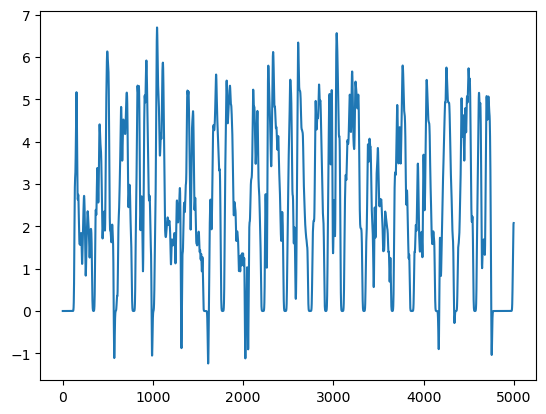

In [116]:
sess.neuropil_corrected_dff(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                            spks_key='channel_0_spks')
sess.neuropil_corrected_dff(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                            spks_key='channel_1_spks')

sess.add_timeseries(licks=sess.vr_data['lick']._values)
sess.add_pos_binned_trial_matrix('licks')
speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries(speed=speed)
sess.add_pos_binned_trial_matrix('speed')

fig,ax = plt.subplots()
ax.plot(speed[:5000])


spks = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')


spks = np.copy(sess.timeseries['channel_1_F_dff'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')



In [117]:
mask_920 = sess.trial_info['block_number']%2==0
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, trial_mask=mask_920)
mask_1040 = sess.trial_info['block_number']%2==1
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, trial_mask=mask_1040)

perm 0
perm 0
perm 0
perm 0


In [118]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
tpu.sess.save_session(sess,output_path)

In [13]:
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    

    
    for cell in cell_inds:
        col = cell % n_cols
        row = int(cell / n_cols)
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma",aspect = 'auto',interpolation='none')

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

In [240]:
# load 
mouse = 'SparseKO_12'
d = sparse_sessions[mouse][1]
date = d['date']
scene = d['scene']
session = d['session']
pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)

In [241]:
sess.trial_info['block_number']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

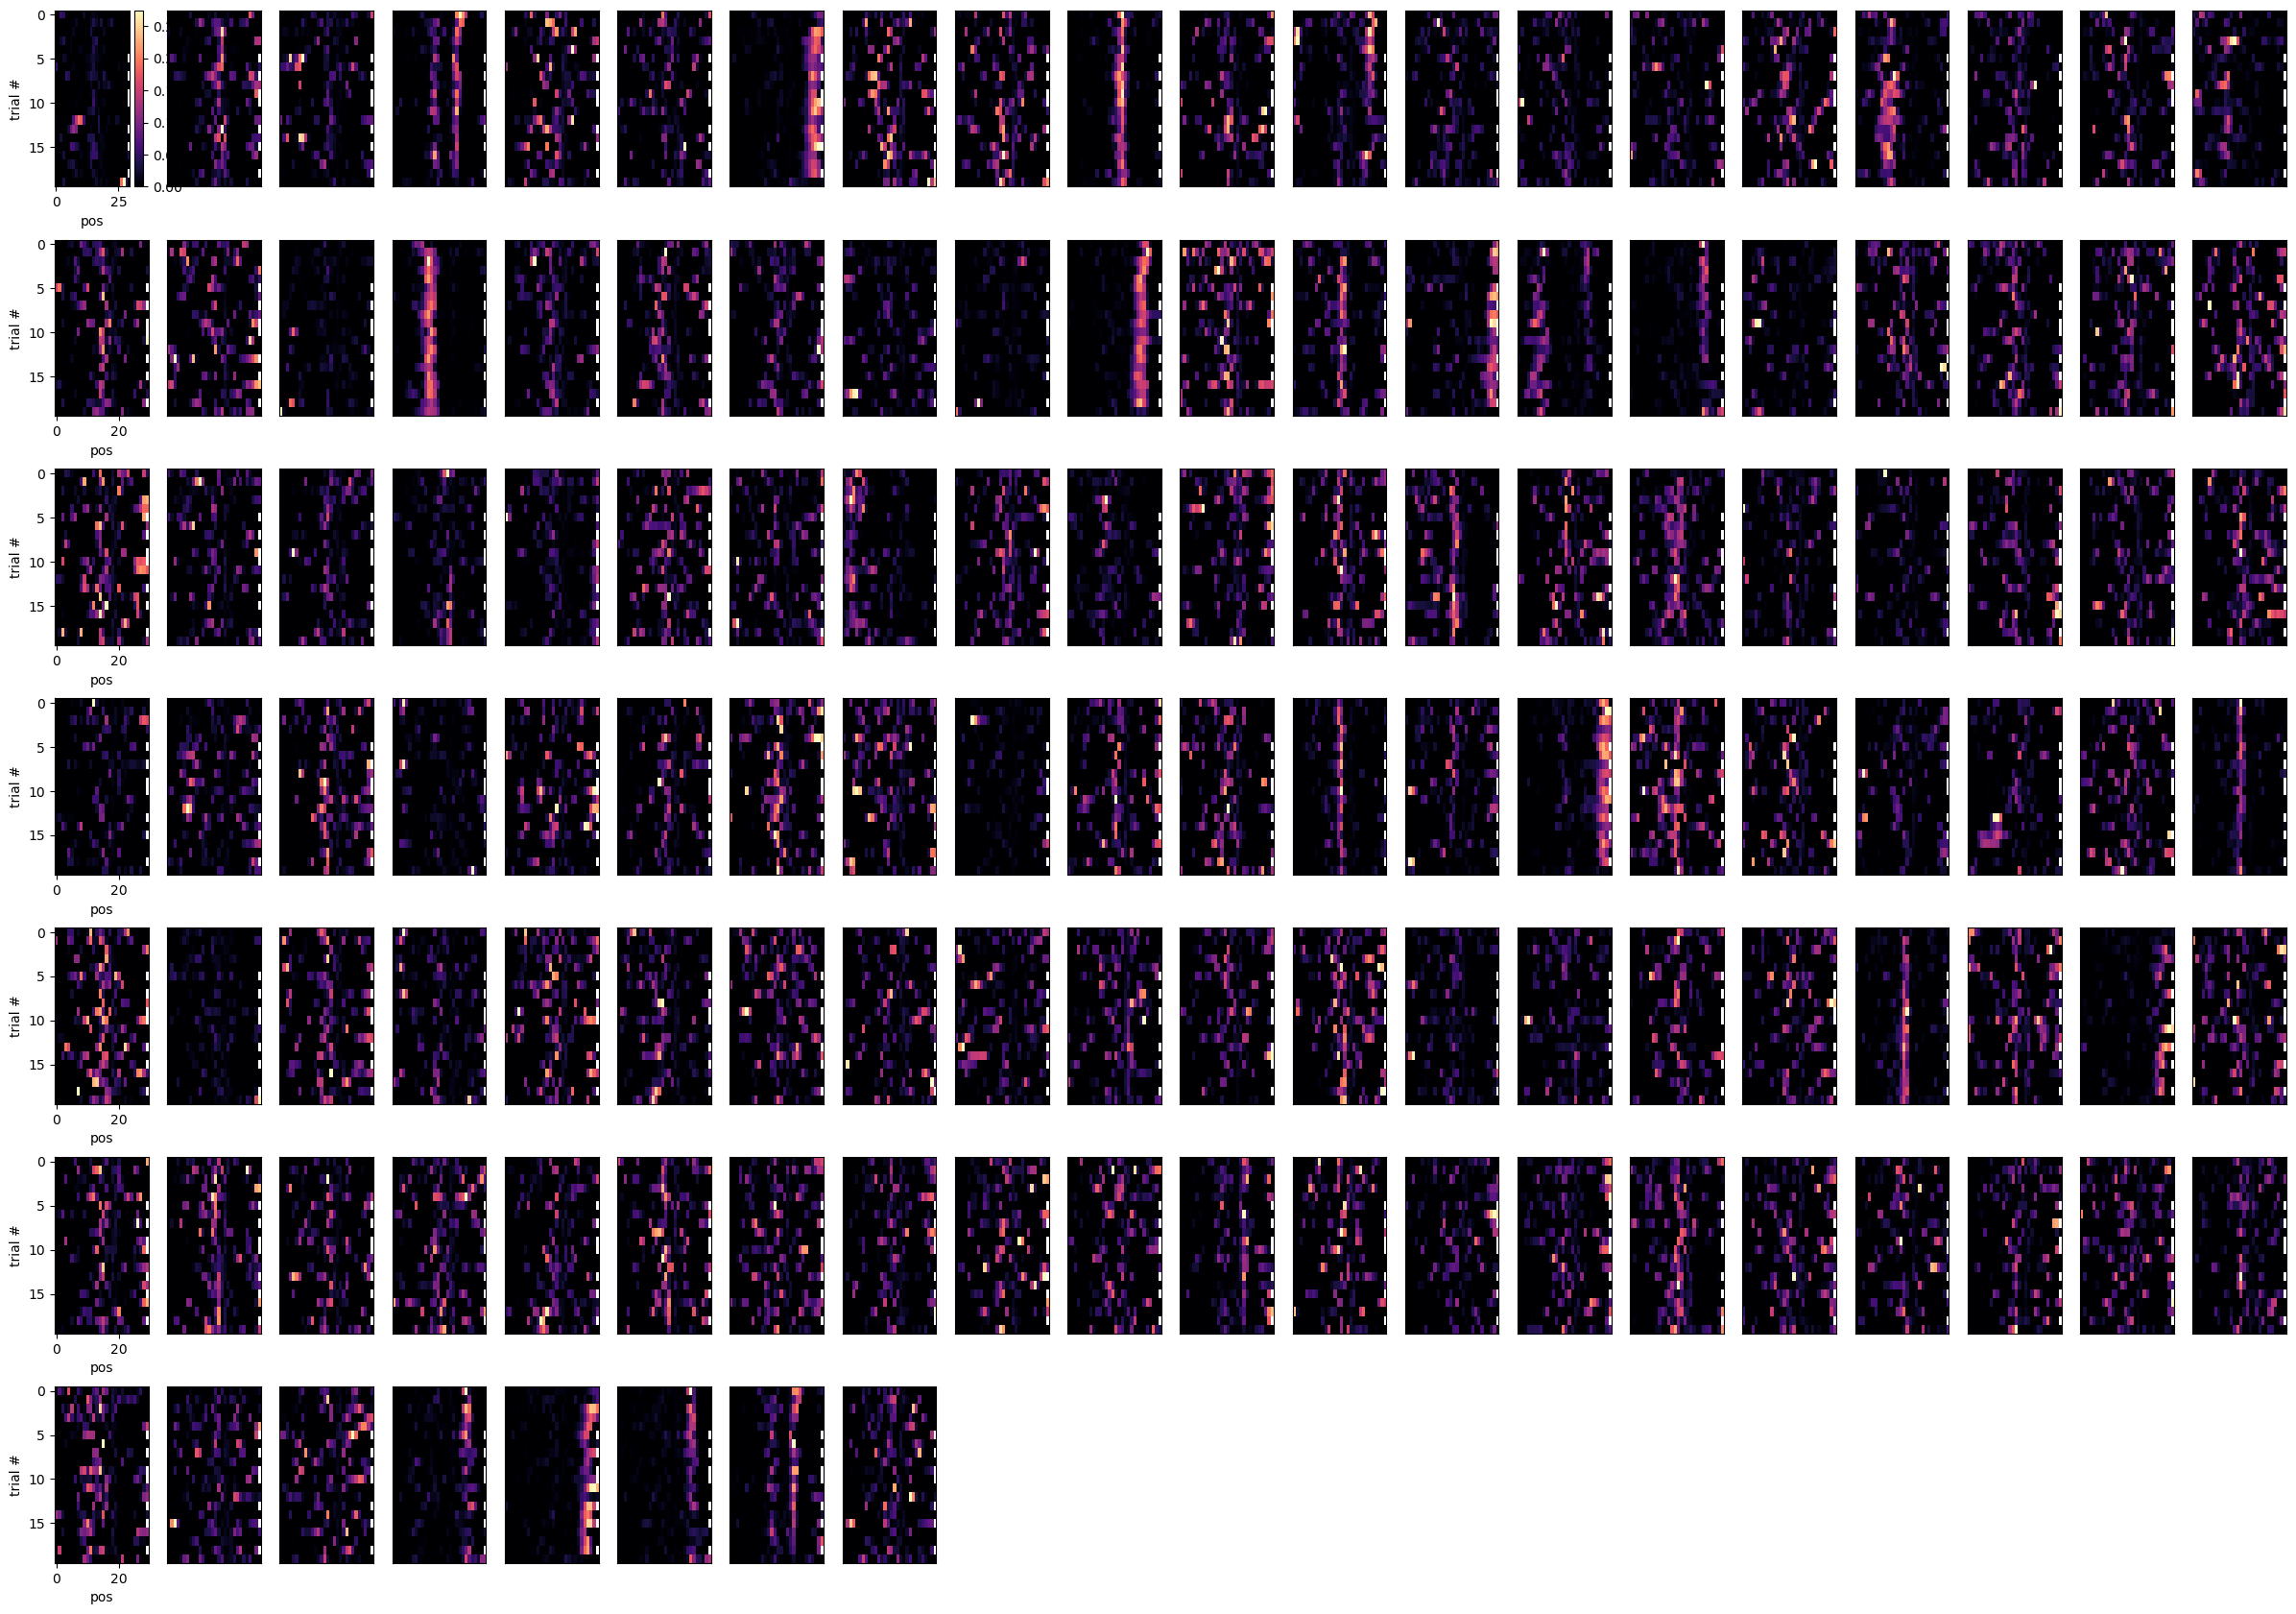

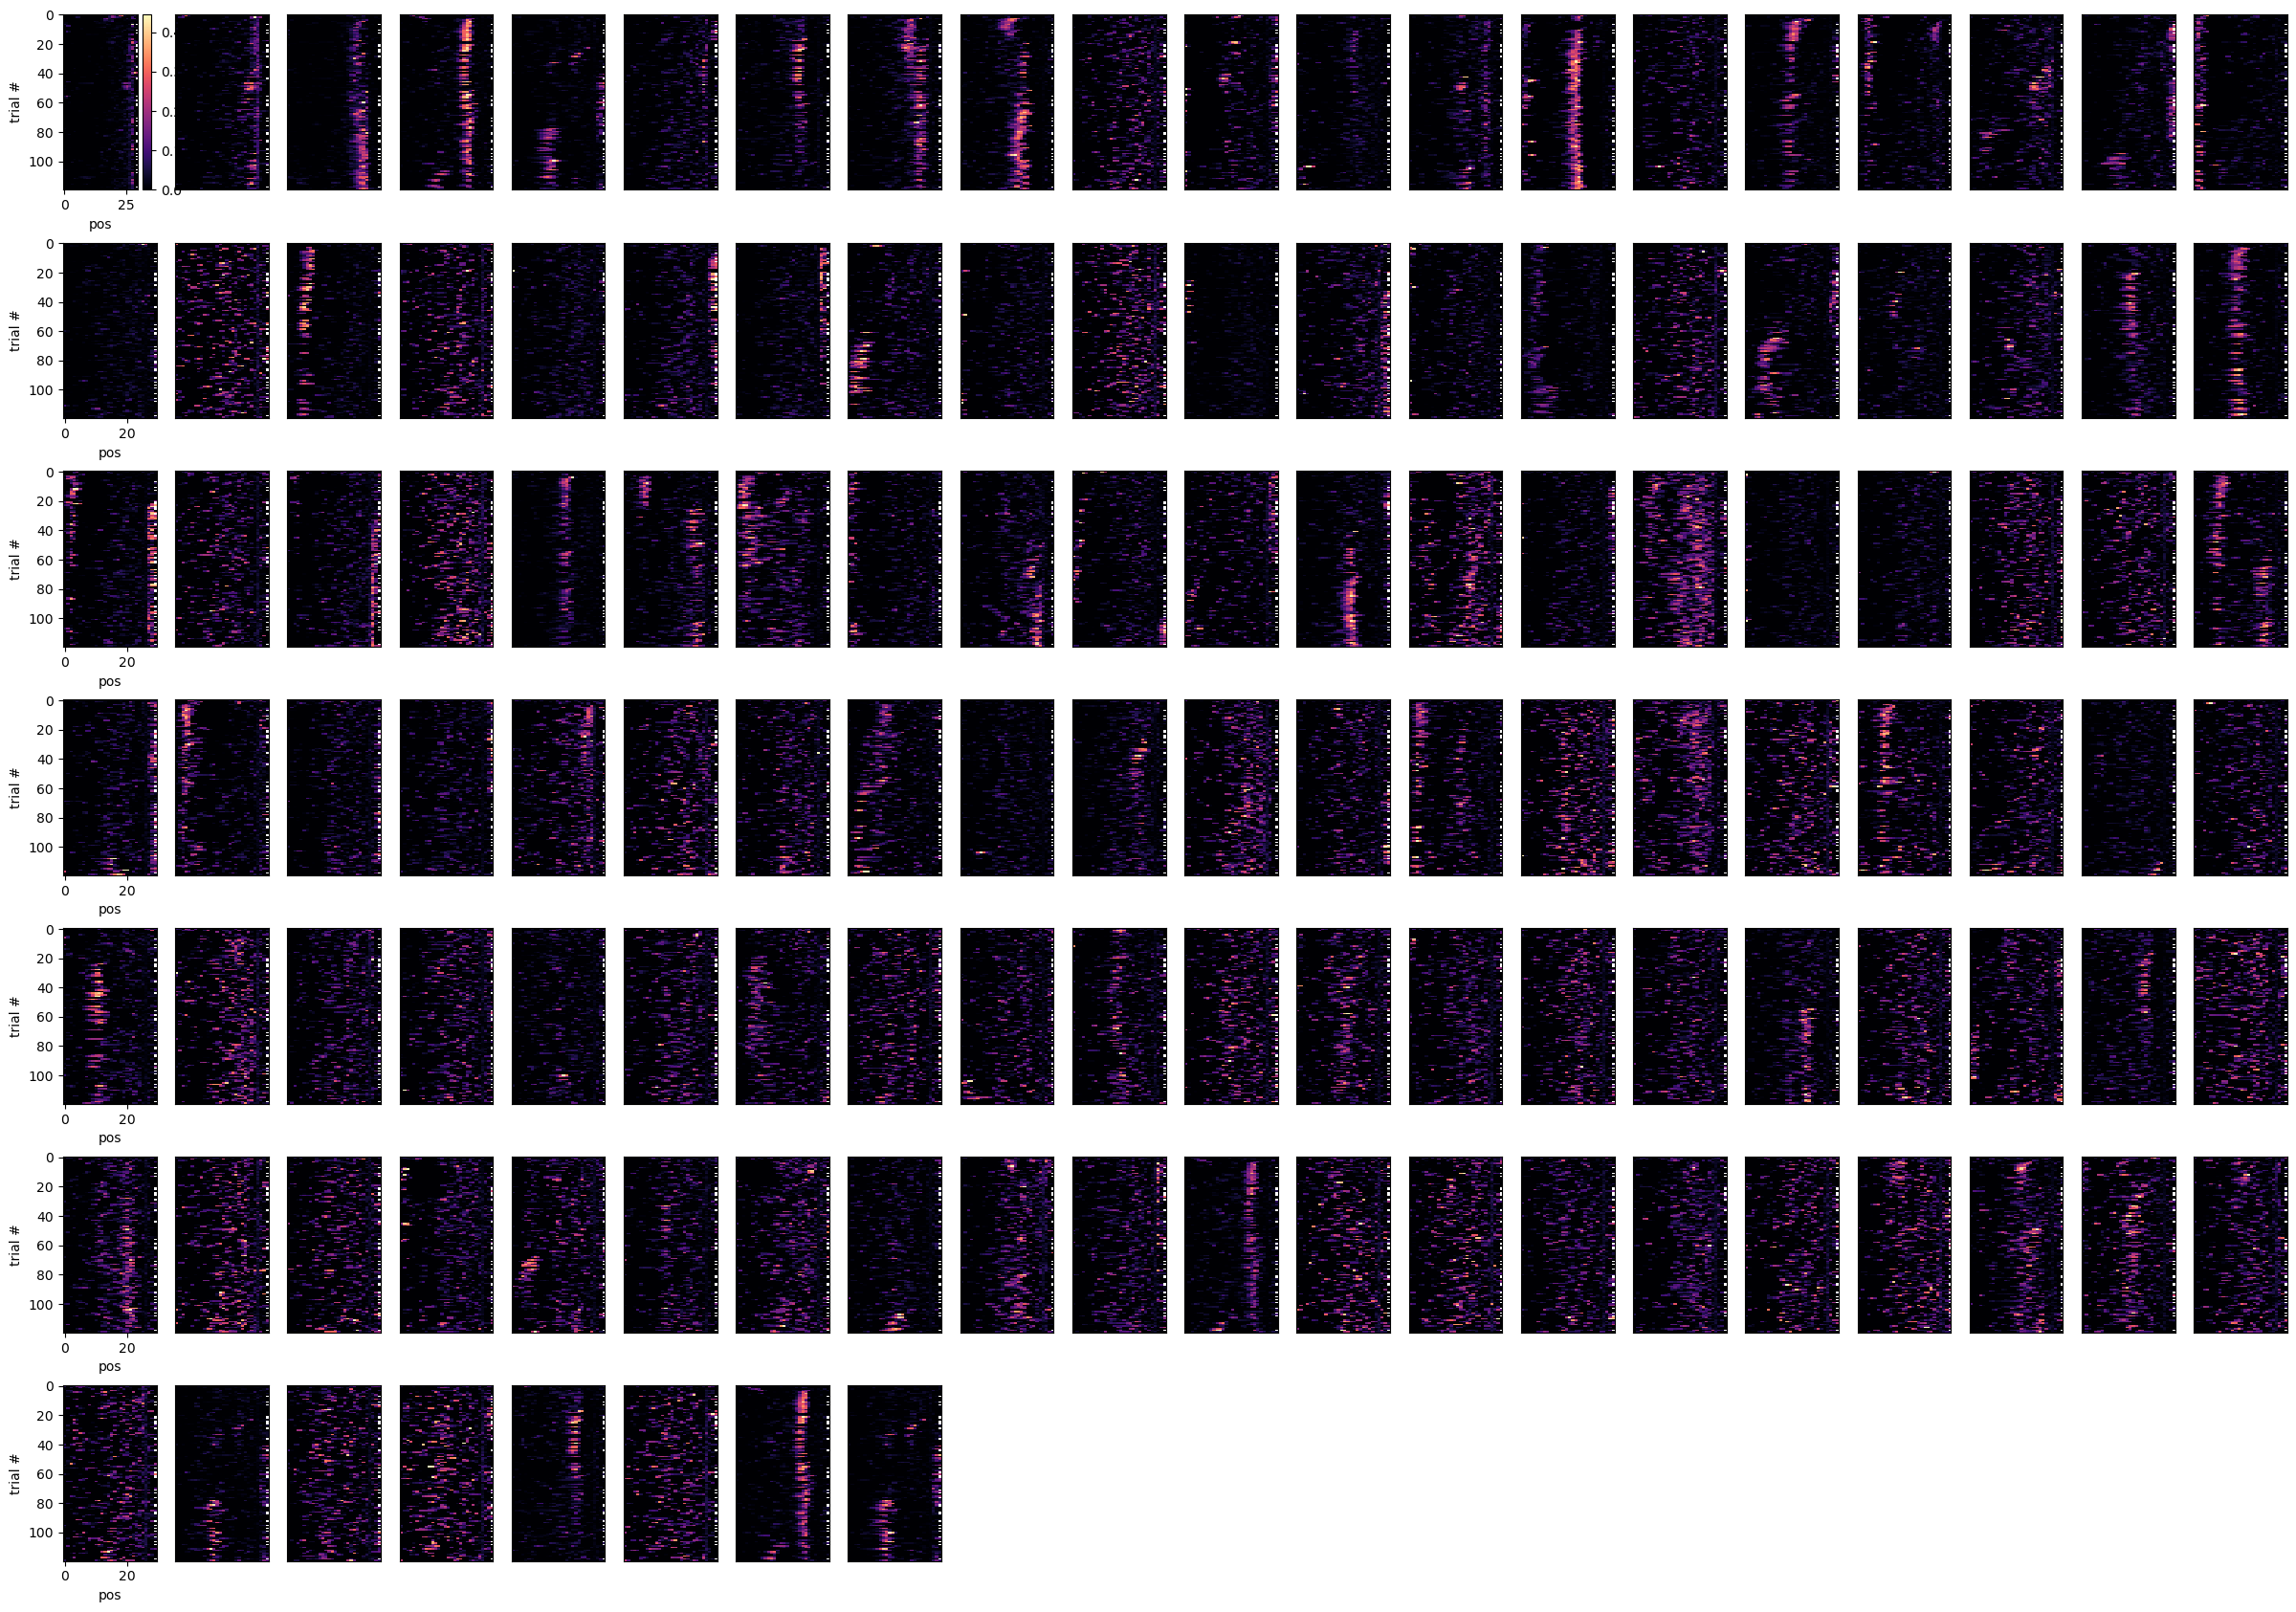

In [208]:
# left trials, odd blocks (channel 1)
trial_mask = (sess.trial_info['LR']==-1)#*((sess.trial_info['block_number']%2)==1)

tmat = sess.trial_matrices['channel_1_spks']
n_cells = tmat.shape[-1]


fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

# right trials, even blocks (channel 1)
trial_mask = (sess.trial_info['LR']==1)#*((sess.trial_info['block_number']%2)==1)
tmat = sess.trial_matrices['channel_1_spks']
n_cells = tmat.shape[-1]


fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

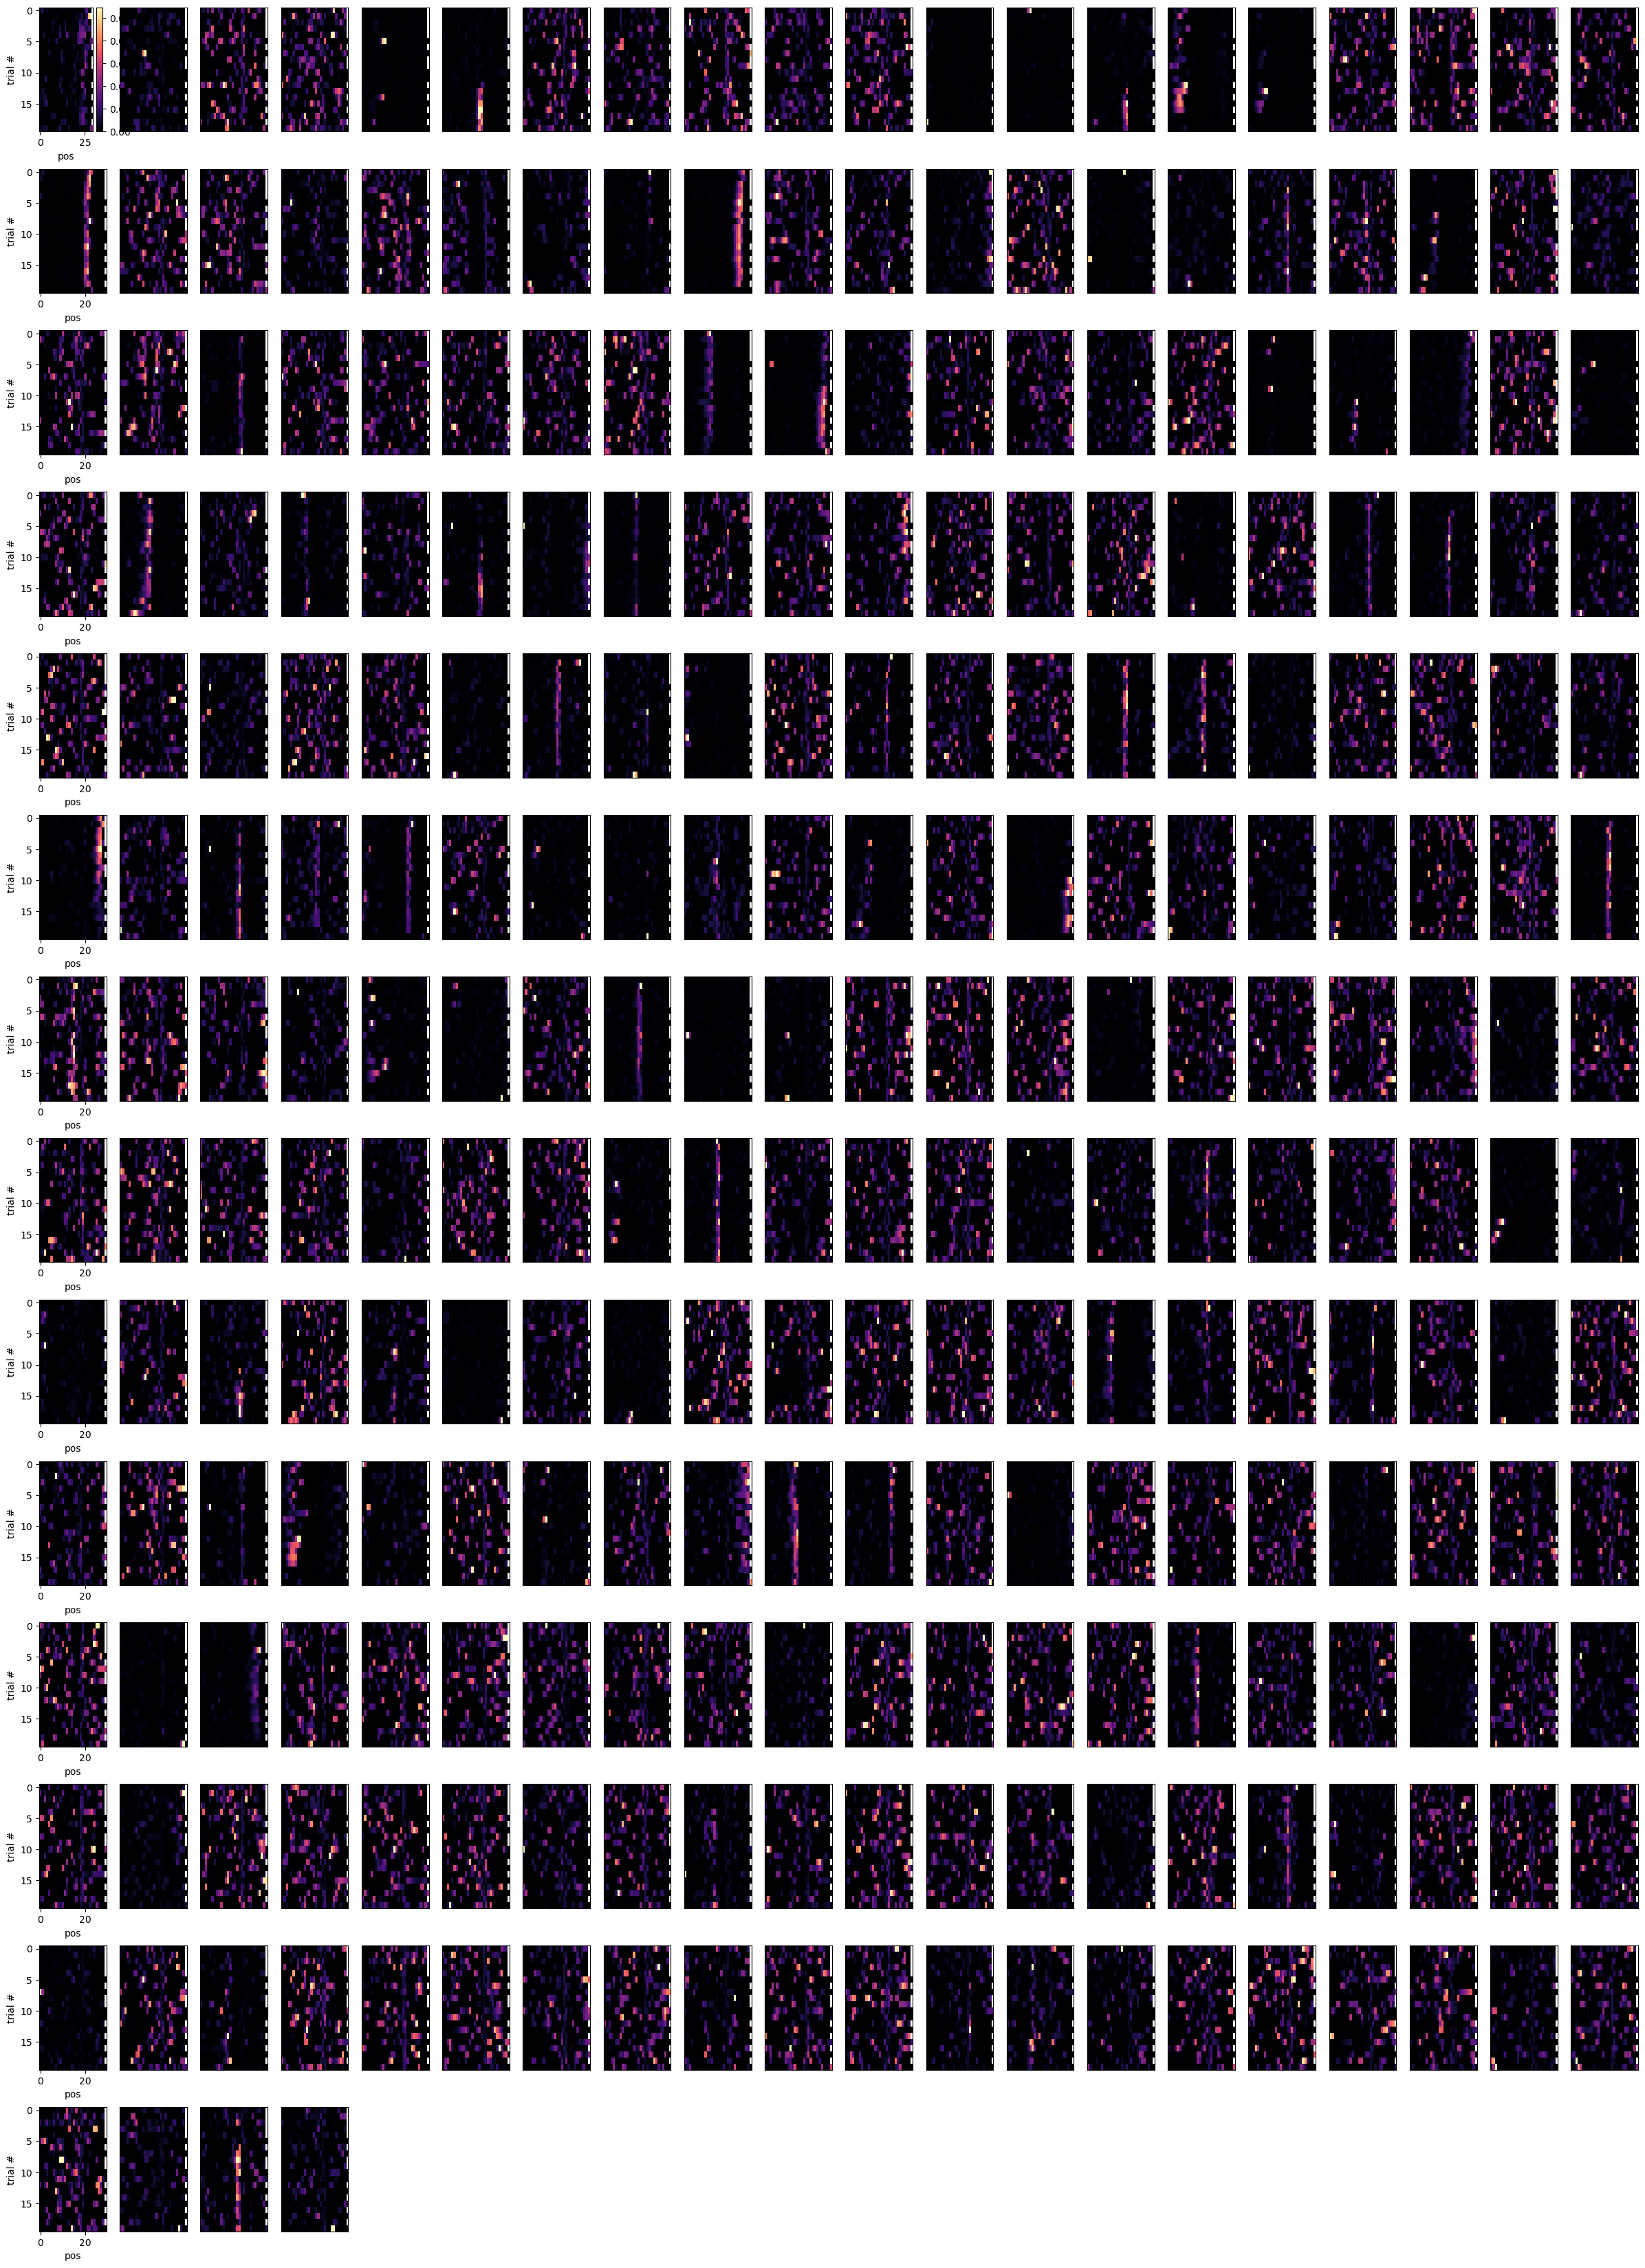

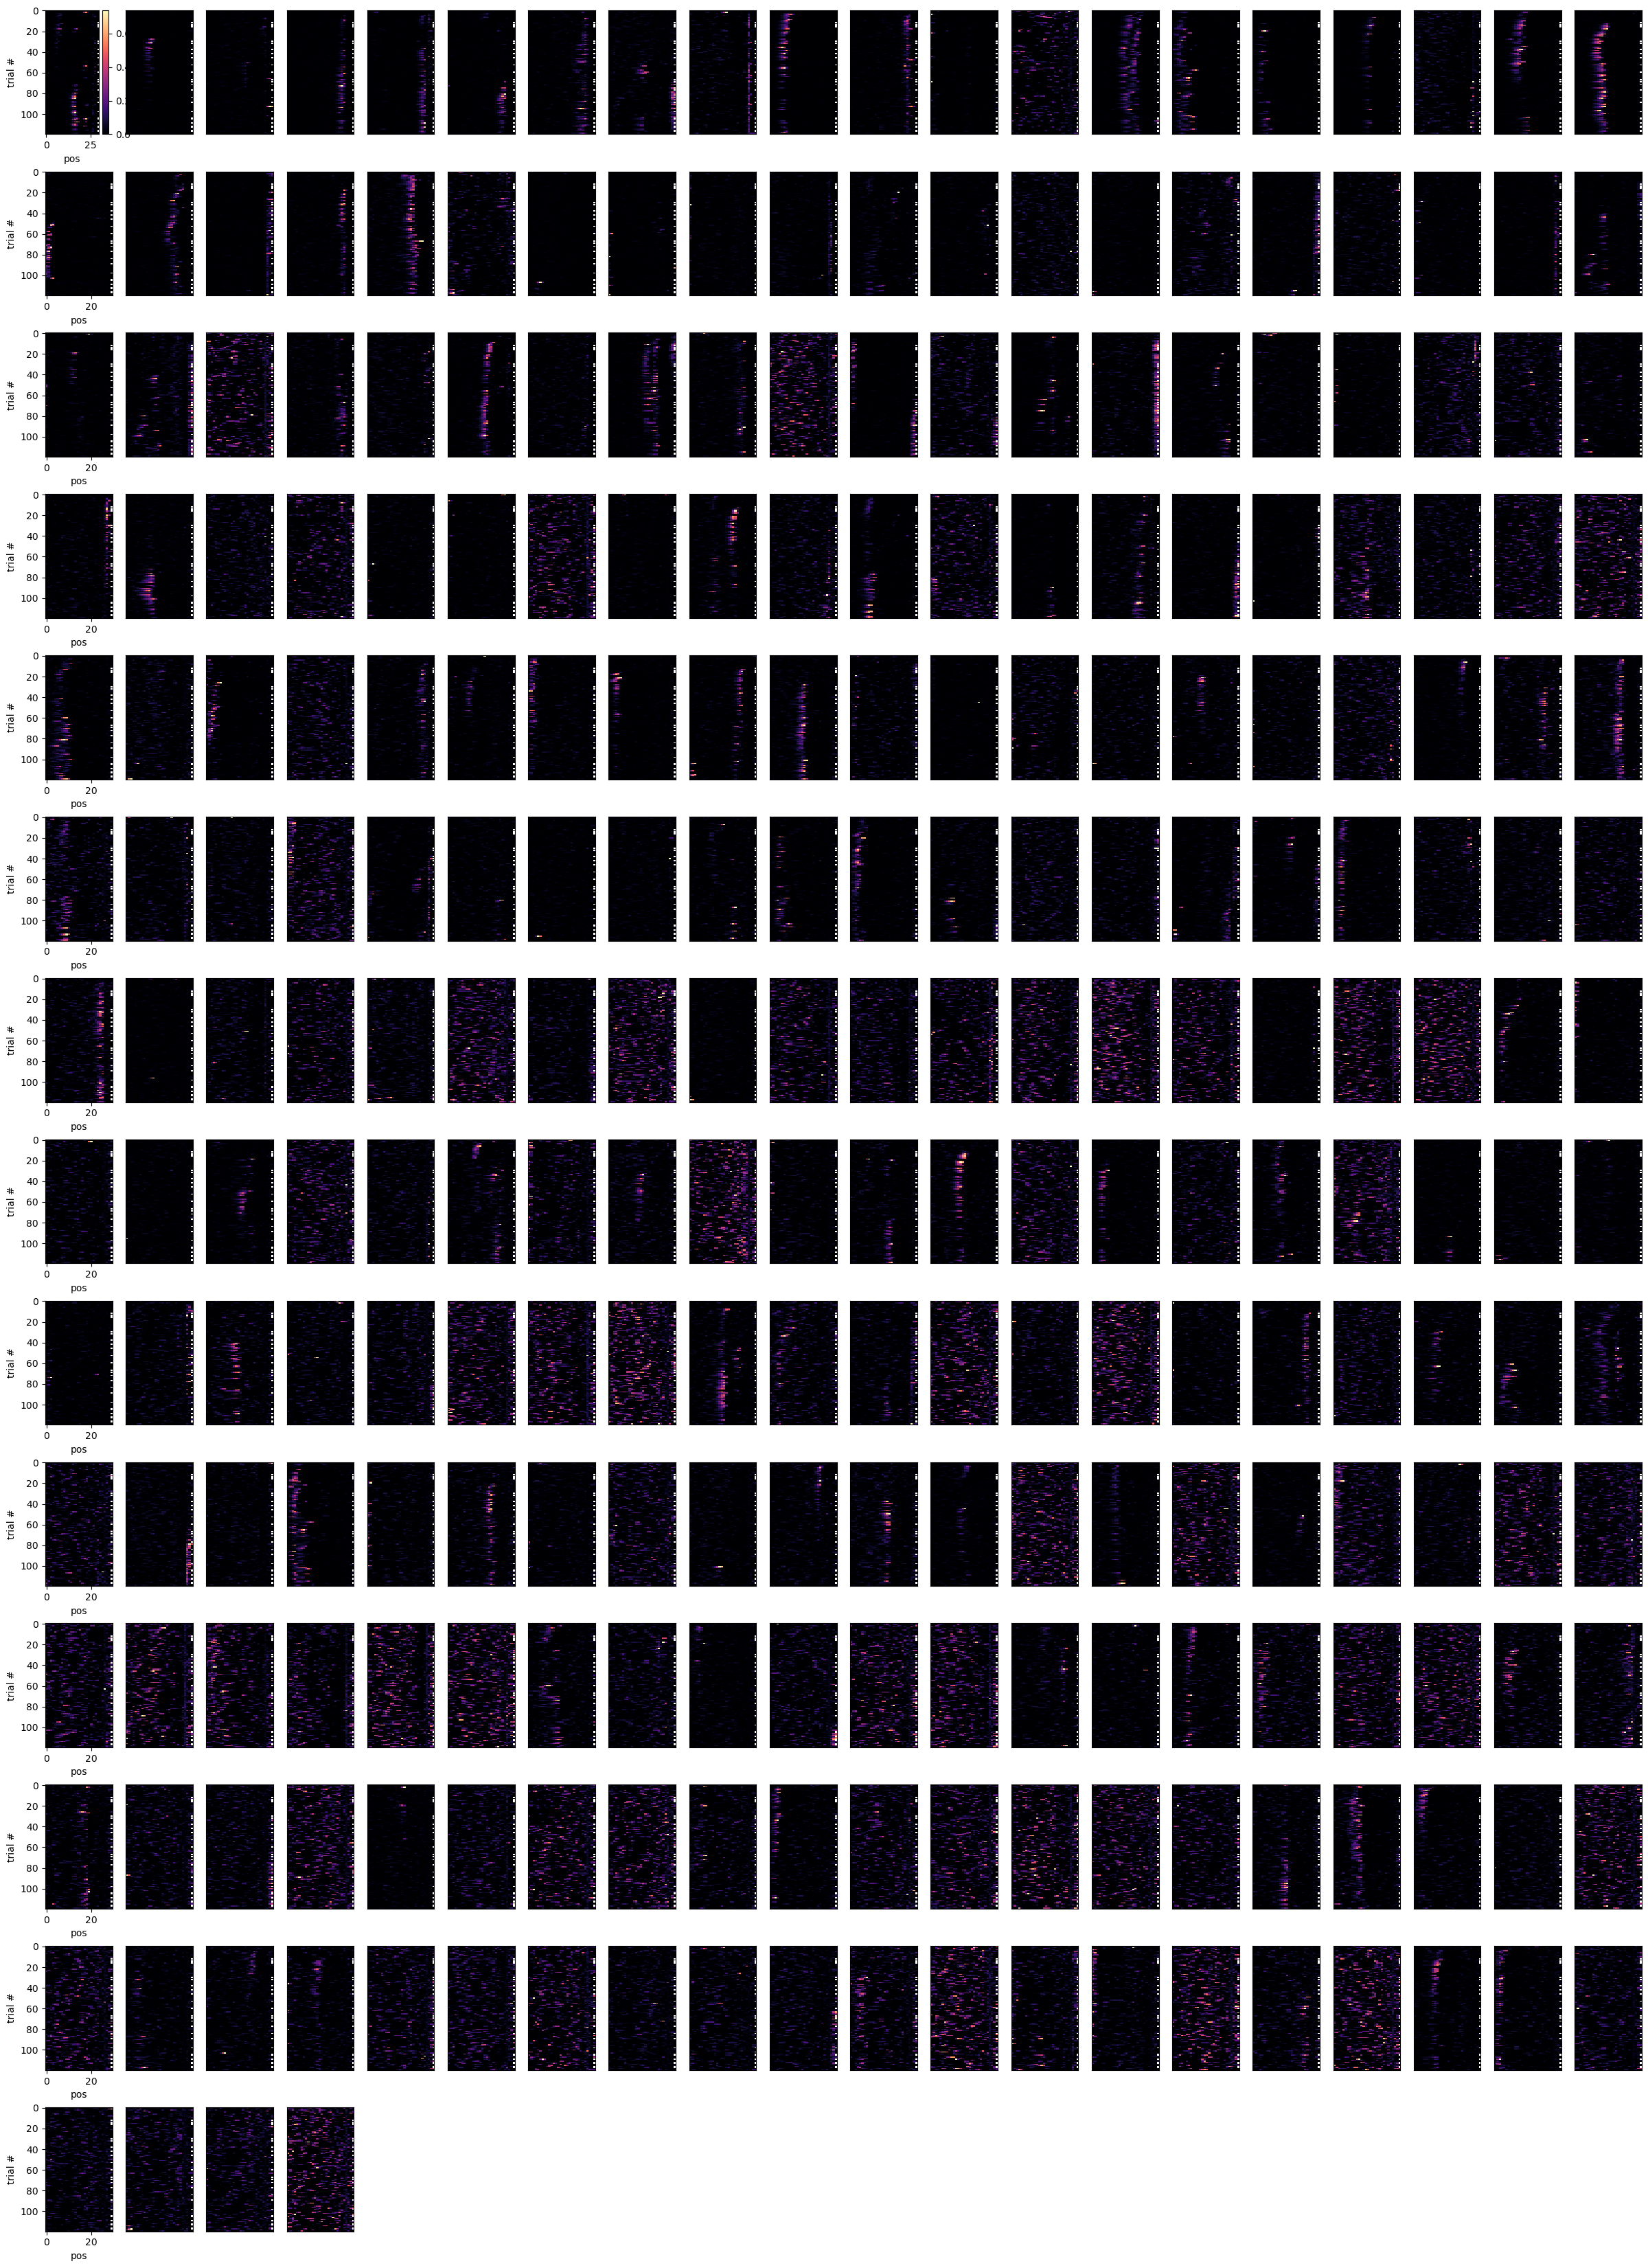

In [209]:
trial_mask = (sess.trial_info['LR']==-1)#*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_0_spks']
n_cells = tmat.shape[-1]


fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

trial_mask = (sess.trial_info['LR']==1)#*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_0_spks']
n_cells = tmat.shape[-1]


fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [24]:
chan0_blocks = sess.trial_info['block_number']%2==0
chan0sig = np.nansum(np.nansum(sess.trial_matrices['channel_1_spks'][chan0_blocks,:,:],axis=0), axis=0)
chan1sig = np.nansum(np.nansum(sess.trial_matrices['channel_1_spks'][~chan0_blocks,:,:],axis=0), axis=0)

(chan1sig>chan0sig).sum()

19

### For loop for each mouse

In [ ]:
for mouse in sparse_mice:
    d = sparse_sessions[mouse][-1]
    print(d)
    date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
    print(scene)
    basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
    stem = os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')
    d.update({
        'mouse': mouse,
        'scan_file': stem + '.sbx',
        'scanheader_file': stem + '.mat',
        'vr_filename': os.path.join("C://Users/esay/data/Stx3/VRData", mouse, date, "%s_%d.sqlite" % (scene, session)),
        'scan_number': scan,
        'prompt_for_keys': False,
        'VR_only': False,
        'scanner': "NLW",
        'n_channels': 2,
    })
    sess = stx.session.YMazeSession(**d)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()
    F = sess.timeseries['channel_0_F']
    trial_ts = np.zeros([F.shape[-1], ]) - 1
    blocknum_ts = np.zeros([F.shape[-1], ]) - 1
    for t, (start, stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
        trial_ts[start:stop] = t
        blocknum_ts[start:stop] = sess.trial_info['block_number'][t]
    mask_920 = (blocknum_ts % 2 == 0) * (blocknum_ts > 0)
    mask_1040 = (blocknum_ts % 2 == 1) * (blocknum_ts > 0)
    sig920 = sess.timeseries['channel_0_F'][:, mask_920].sum(axis=-1)
    sig1040 = sess.timeseries['channel_0_F'][:, mask_1040].sum(axis=-1)
    channel_0_mask = sig920 > sig1040
    sess.timeseries['channel_0_F'] = sess.timeseries['channel_0_F'][channel_0_mask, :]
    sess.timeseries['channel_0_Fneu'] = sess.timeseries['channel_0_Fneu'][channel_0_mask, :]
    sig920 = sess.timeseries['channel_1_F'][:, mask_920].sum(axis=-1)
    sig1040 = sess.timeseries['channel_1_F'][:, mask_1040].sum(axis=-1)
    channel_1_mask = sig1040 > sig920
    sess.timeseries['channel_1_F'] = sess.timeseries['channel_1_F'][channel_1_mask, :]
    sess.timeseries['channel_1_Fneu'] = sess.timeseries['channel_1_Fneu'][channel_1_mask, :]
    sess.neuropil_corrected_dff(Fkey='channel_0_F', Fneukey='channel_0_Fneu', tau=sess.s2p_ops['channel_0']['tau'], spks_key='channel_0_spks')
    sess.neuropil_corrected_dff(Fkey='channel_1_F', Fneukey='channel_1_Fneu', tau=sess.s2p_ops['channel_1']['tau'], spks_key='channel_1_spks')
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values * sess.scan_info['frame_rate']
    sess.add_timeseries(speed=speed)
    sess.add_pos_binned_trial_matrix('speed')
    fig, ax = plt.subplots()
    ax.plot(speed[:5000])
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    spks[:, speed < 2] = np.nan
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:, speed < 2] = np.nan
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')
    mask_920 = sess.trial_info['block_number'] % 2 == 0
    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, trial_mask=mask_920)
    mask_1040 = sess.trial_info['block_number'] % 2 == 1
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, trial_mask=mask_1040)
    tpu.sess.save_session(sess, 'C:/Users/esay/data/Stx3/YMazeSessPkls')